# LucidBench Benchmark Analysis

This notebook provides comprehensive analysis of filesystem benchmark results across different storage devices and filesystems.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Overview and Summary Statistics](#overview)
3. [Performance Analysis by Storage Type](#storage-analysis)
4. [Filesystem Comparison](#filesystem-analysis)
5. [I/O Pattern Analysis](#io-analysis)
6. [Resource Utilization](#resource-analysis)
7. [Statistical Analysis](#statistical-analysis)
8. [Comparative Analysis](#comparative-analysis)
9. [Recommendations and Conclusions](#conclusions)

## 1. Setup and Data Loading <a name="setup"></a>

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
# Define consistent colors for filesystems
fs_colors = {
    'ext4': '#1f77b4',  # blue
    'ext3': '#ff7f0e',  # orange  
    'ext2': '#2ca02c',  # green
    'xfs': '#d62728',   # red
    'btrfs': '#9467bd', # purple
    'ntfs': '#8c564b',  # brown
    'vfat': '#e377c2'   # pink
}

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [3]:
def load_benchmark_data(run_dir):
    """Load all benchmark and monitoring data from a run directory."""
    data = []
    
    for test_dir in Path(run_dir).glob('*'):
        if not test_dir.is_dir():
            continue
            
        # Parse test directory name
        parts = test_dir.name.split('_')
        if len(parts) < 4:
            continue
            
        storage_type = parts[0]
        device = parts[1]
        filesystem = parts[2]
        test_type = '_'.join(parts[3:])
        
        # Load test data
        test_file = test_dir / 'test.json'
        if test_file.exists():
            with open(test_file) as f:
                content = f.read()
                start_idx = content.find('{')
                if start_idx >= 0:
                    test_data = json.loads(content[start_idx:])
                else:
                    test_data = json.loads(content)
                
                # Load monitoring data
                monitor_file = test_dir / 'monitoring.json'
                if monitor_file.exists():
                    with open(monitor_file) as f:
                        monitor_data = json.load(f)
                        
                        # Combine data
                        if 'test_data' in locals() and 'monitor_data' in locals():
                            data.append({
                                'storage_type': storage_type,
                                'device': device,
                                'filesystem': filesystem,
                                'test_type': test_type,
                                'test_data': test_data,
                                'monitor_data': monitor_data
                            })
    
    return pd.DataFrame(data)

# Load data from the most recent run
results_dir = Path('../results')
latest_run = max(results_dir.glob('run_*'), key=os.path.getctime)
df = load_benchmark_data(latest_run)
print(f"Loaded data from {latest_run.name}")

Loaded data from run_20250427_234135


## 2. Overview and Summary Statistics <a name="overview"></a>

In [4]:
def extract_performance_metrics(row):
    """Extract key performance metrics from test data."""
    test_data = row['test_data']
    job = test_data['jobs'][0]
    test_type = row['test_type']
    
    # Determine if this is a read or write test
    is_read_test = 'read' in test_type
    
    metrics = {
        'iops': job['read']['iops'] if is_read_test else job['write']['iops'],
        'bandwidth': job['read']['bw'] if is_read_test else job['write']['bw'],
        'latency': job['read']['lat_ns']['mean'] if is_read_test else job['write']['lat_ns']['mean'],
        'runtime': job.get('runtime', None)
    }
    
    return pd.Series(metrics)

# Extract performance metrics
performance_df = df.apply(extract_performance_metrics, axis=1)
df = pd.concat([df, performance_df], axis=1)

# Display summary statistics
print("\nSummary Statistics by Storage Type and Filesystem:")
summary = df.groupby(['storage_type', 'filesystem']).agg({
    'iops': ['mean', 'std', 'min', 'max'],
    'bandwidth': ['mean', 'std', 'min', 'max'],
    'latency': ['mean', 'std', 'min', 'max']
}).round(2)
display(summary)


Summary Statistics by Storage Type and Filesystem:


iops                                 bandwidth                                        latency                                          
                             mean       std      min        max        mean         std       min        max          mean           std           min           max
storage_type filesystem                                                                                                                                             
HDD          btrfs         243.20     31.97   224.37     291.05   117599.75   134603.50     897.0   234764.0  1.330585e+08  1.547450e+07  1.099335e+08  1.426070e+08
             ext2          175.52     79.58   100.37     259.58    84171.50   109908.52     460.0   232410.0  2.143106e+08  9.661486e+07  1.232628e+08  3.165003e+08
             ext3          175.02     78.72   100.09     257.37    84067.00   109836.12     463.0   232281.0  2.144025e+08  9.619820e+07  1.243215e+08  3.171924e+08
             ext4          230.31     34.30   208.26     281.41   110971.75   127023.98     833.0   223374.0  1.409504e+08  1.838856e+07  1.137028e+08  1.536348e+08
             ntfs         9388.24  17002.00   133.57   34873.49   686754.75   793607.88     534.0  1726761.0  7.407539e+07  1.112951e+08  9.158244e+05  2.395449e+08
             vfat          147.35    117.02     0.00     274.80    30933.00    60613.76       0.0   121851.0  1.369791e+08  1.110981e+08  0.000000e+00  2.678751e+08
             xfs           241.13     33.68   214.26     290.43   118222.75   135346.89     857.0   235582.0  1.344233e+08  1.687346e+07  1.101695e+08  1.493296e+08
NVMe         btrfs       24226.72  39104.99  1633.17   82617.08  1190281.00  1242254.81   40008.0  2718278.0  8.778315e+06  8.715936e+06  3.864838e+05  1.955125e+07
             ext2        41196.32  58379.08  1352.26  125547.89  1184340.00  1143129.40  140956.0  2709498.0  9.170515e+06  1.097653e+07  2.540123e+05  2.350814e+07
             ext3        39995.97  57055.94  1240.08  122554.46  1103520.25  1056072.32  134917.0  2519101.0  9.943538e+06  1.197304e+07  2.602802e+05  2.564301e+07
             ext4        46855.52  58478.42  1913.12  125367.77  1332587.50  1155650.63  230253.0  2639587.0  7.463895e+06  8.344051e+06  2.544177e+05  1.670154e+07
             ntfs         9796.01  17711.95   127.51   36343.27   731068.50   860525.91     510.0  1878326.0  7.631343e+07  1.173010e+08  8.791321e+05  2.509305e+08
             vfat        35424.96  43129.55     0.00   88323.45   261890.75   206723.22       0.0   482651.0  1.713611e+07  3.362955e+07  0.000000e+00  6.757906e+07
             xfs         38455.01  57503.74  1840.07  123014.55  1300392.00  1216288.80  105236.0  2720041.0  7.700020e+06  8.346075e+06  2.592703e+05  1.736146e+07
SSD          btrfs        7820.49   9191.93   472.71   19544.02   282023.75   256573.54   43018.0   522850.0  3.370955e+07  3.632652e+07  1.635174e+06  6.764454e+07
             ext2         8780.89   9840.12   378.73   19586.37   259106.75   225977.00   58635.0   511625.0  3.798088e+07  4.246213e+07  1.631772e+06  8.414086e+07
             ext3         8755.49   9816.28   368.01   19533.83   256287.25   224075.12   58481.0   511687.0  3.859024e+07  4.335040e+07  1.636321e+06  8.658831e+07
             ext4         8391.63   9188.55   399.80   16600.85   256014.75   222208.72   64373.0   483883.0  3.788818e+07  4.179290e+07  1.925732e+06  7.996131e+07
             ntfs         9761.84  17687.43   130.27   36272.87   713318.75   846692.76     521.0  1853426.0  7.554200e+07  1.144046e+08  8.806148e+05  2.456175e+08
             vfat         9016.33  10386.80     0.00   19611.28    87070.00    85648.63       0.0   204820.0  4.076104e+07  7.912891e+07  0.000000e+00  1.594474e+08
             xfs          9095.30  10038.48   483.08   19507.66   289783.25   253221.60   63519.0   522915.0  3.310901e+07  3.615384e+07  1.638377e+06  6.620603e+07

## 3. Performance Analysis by Storage Type <a name="storage-analysis"></a>

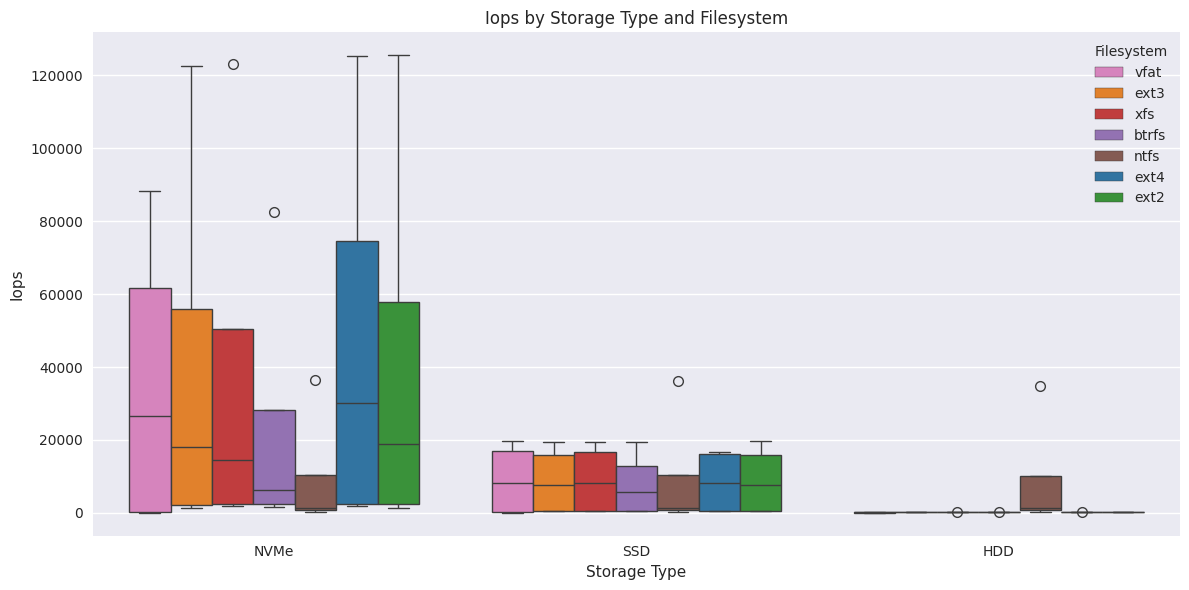

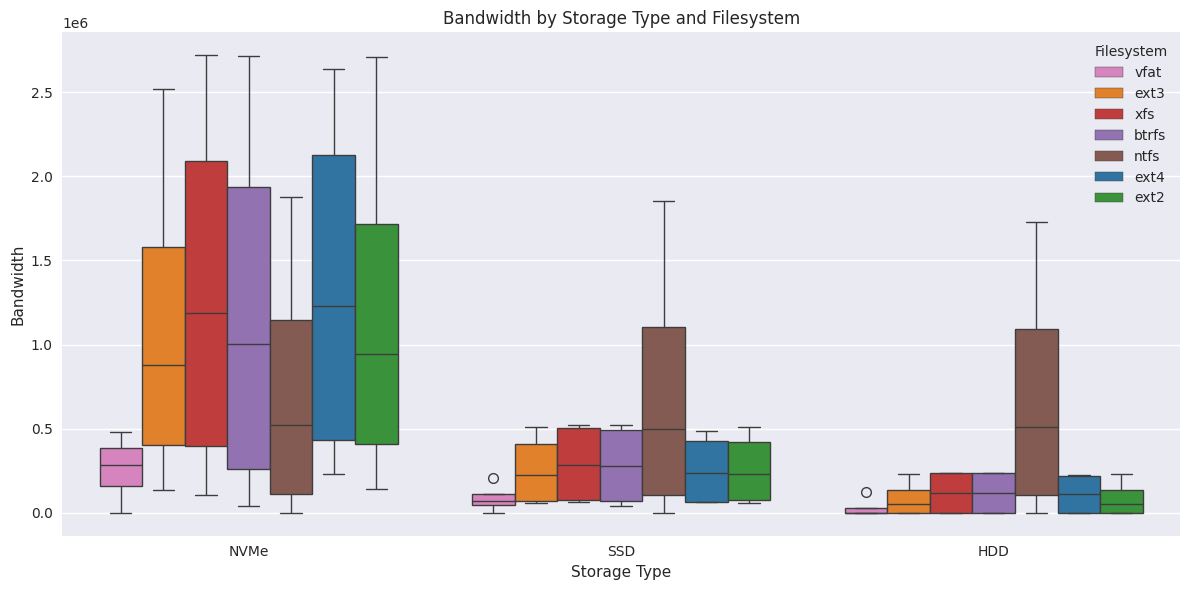

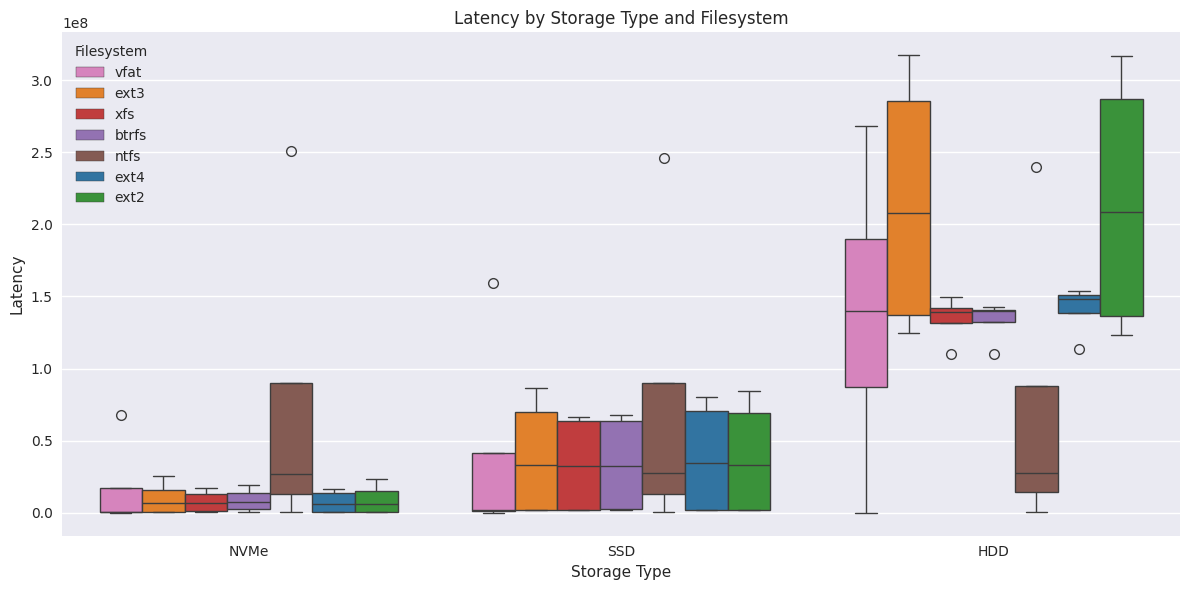

In [5]:
def plot_storage_performance(df, metric):
    """Plot performance metrics by storage type."""
    plt.figure(figsize=(12, 6))
    
    # Create box plot
    sns.boxplot(data=df, x='storage_type', y=metric, hue='filesystem', palette=fs_colors)
    
    plt.title(f'{metric.title()} by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel(metric.title())
    plt.xticks(rotation=0)
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

# Plot performance metrics
for metric in ['iops', 'bandwidth', 'latency']:
    plot_storage_performance(df, metric)

## 4. Filesystem Comparison <a name="filesystem-analysis"></a>


IOPS Comparison:


filesystem                            btrfs           ext2           ext3           ext4          ntfs          vfat            xfs
storage_type test_type                                                                                                             
HDD          random_read         291.049988     259.577509     257.369935     281.408540  34873.486763    274.804210     290.429866
             random_write        224.369636     115.179494     115.785790     208.261990    133.572202    195.559394     214.259616
             sequential_read     229.262286     226.962930     226.837238     213.433380   1686.290655      0.000000     229.776731
             sequential_write    228.100462     100.370016     100.092860     218.139213    859.601259    119.024787     230.060661
NVMe         random_read       82617.081626  125547.892720  122554.464703  125367.766619  36343.269097  88323.450135  123014.547161
             random_write      10002.060361   35239.145046   33729.284611   57563.460694    127.512081  52904.944501   26309.112806
             sequential_read    2654.569021    2645.994832    2460.060060    2577.721838   1834.303627      0.000000    2656.290532
             sequential_write   1633.173844    1352.261472    1240.084771    1913.124708    878.969957    471.454880    1840.071878
SSD          random_read       19544.024454   19586.371787   19533.830104   16600.848585  36272.865643  19611.281514   19507.664831
             random_write      10754.625641   14658.838003   14620.412716   16093.314507    130.271774  16253.968254   15879.815847
             sequential_read     510.595861     499.634057     499.695010     399.804783   1809.986743      0.000000     510.659519
             sequential_write    472.706290     378.733241     368.014376     472.542686    834.215886    200.068383     483.075834

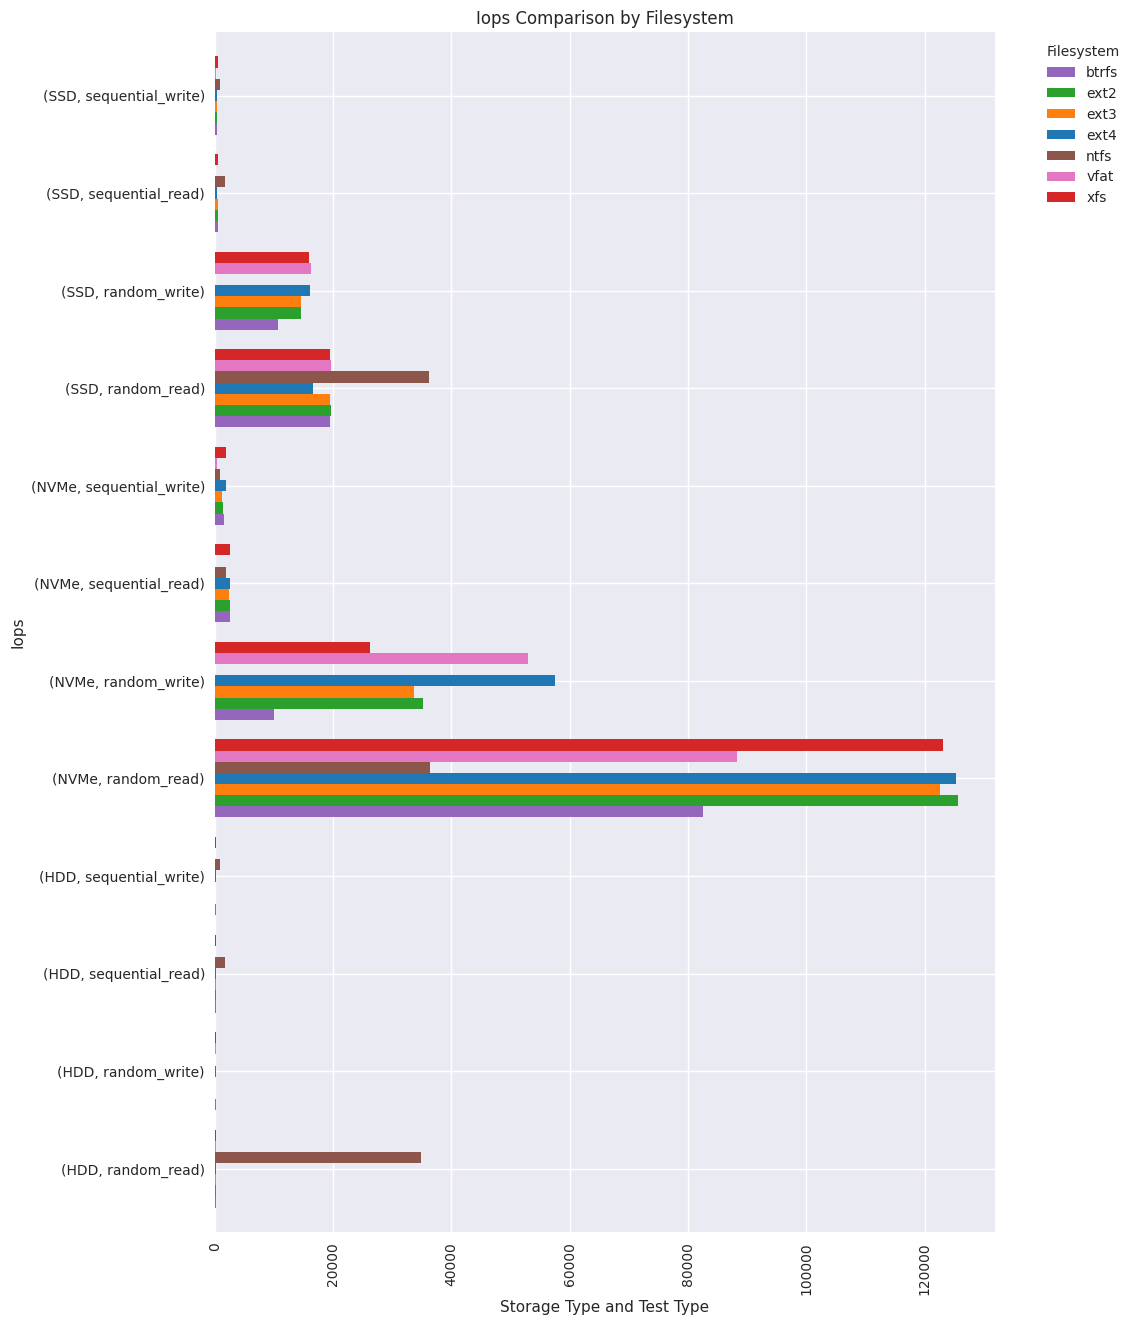


BANDWIDTH Comparison:


filesystem                         btrfs       ext2       ext3       ext4       ntfs      vfat        xfs
storage_type test_type                                                                                   
HDD          random_read          1164.0     1038.0     1029.0     1125.0   139493.0    1099.0     1161.0
             random_write          897.0      460.0      463.0      833.0      534.0     782.0      857.0
             sequential_read    234764.0   232410.0   232281.0   218555.0  1726761.0       0.0   235291.0
             sequential_write   233574.0   102778.0   102495.0   223374.0   880231.0  121851.0   235582.0
NVMe         random_read        330468.0   502191.0   490217.0   501471.0   145373.0  353293.0   492058.0
             random_write        40008.0   140956.0   134917.0   230253.0      510.0  211619.0   105236.0
             sequential_read   2718278.0  2709498.0  2519101.0  2639587.0  1878326.0       0.0  2720041.0
             sequential_write  1672370.0  1384715.0  1269846.0  1959039.0   900065.0  482651.0  1884233.0
SSD          random_read         78176.0    78345.0    78135.0    66403.0   145091.0   78445.0    78030.0
             random_write        43018.0    58635.0    58481.0    64373.0      521.0   65015.0    63519.0
             sequential_read    522850.0   511625.0   511687.0   409400.0  1853426.0       0.0   522915.0
             sequential_write   484051.0   387822.0   376846.0   483883.0   854237.0  204820.0   494669.0

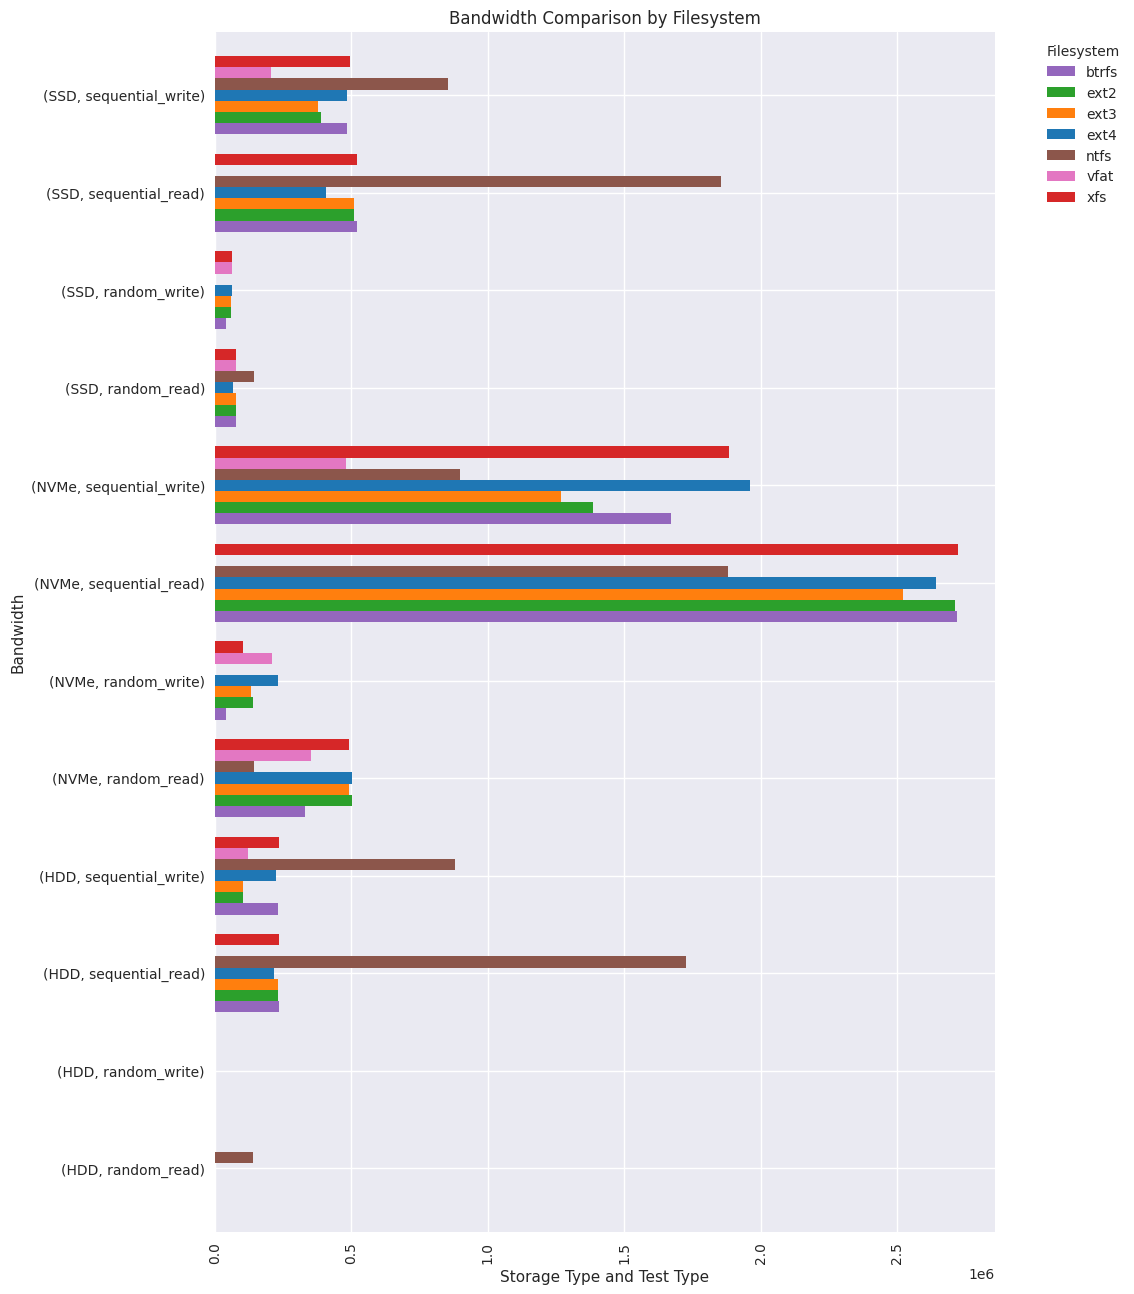


LATENCY Comparison:


filesystem                            btrfs          ext2          ext3          ext4          ntfs          vfat           xfs
storage_type test_type                                                                                                         
HDD          random_read       1.099335e+08  1.232628e+08  1.243215e+08  1.137028e+08  9.158244e+05  1.164325e+08  1.101695e+08
             random_write      1.426070e+08  2.765953e+08  2.751344e+08  1.536348e+08  2.395449e+08  1.636089e+08  1.493296e+08
             sequential_read   1.394754e+08  1.408839e+08  1.409617e+08  1.498208e+08  1.878933e+07  0.000000e+00  1.391576e+08
             sequential_write  1.402183e+08  3.165003e+08  3.171924e+08  1.466432e+08  3.705144e+07  2.678751e+08  1.390365e+08
NVMe         random_read       3.864838e+05  2.540123e+05  2.602802e+05  2.544177e+05  8.791321e+05  3.616420e+05  2.592703e+05
             random_write      3.195223e+06  9.062730e+05  9.469127e+05  5.548055e+05  2.509305e+08  6.037502e+05  1.213946e+06
             sequential_read   1.198030e+07  1.201364e+07  1.292395e+07  1.234481e+07  1.727433e+07  0.000000e+00  1.196540e+07
             sequential_write  1.955125e+07  2.350814e+07  2.564301e+07  1.670154e+07  3.616977e+07  6.757906e+07  1.736146e+07
SSD          random_read       1.635174e+06  1.631772e+06  1.636321e+06  1.925733e+06  8.806149e+05  1.630163e+06  1.638377e+06
             random_write      2.973479e+06  2.180709e+06  2.186319e+06  1.986038e+06  2.456175e+08  1.966600e+06  2.012452e+06
             sequential_read   6.258500e+07  6.397019e+07  6.395002e+07  7.996131e+07  1.750670e+07  0.000000e+00  6.257917e+07
             sequential_write  6.764454e+07  8.414086e+07  8.658831e+07  6.767964e+07  3.816323e+07  1.594474e+08  6.620603e+07

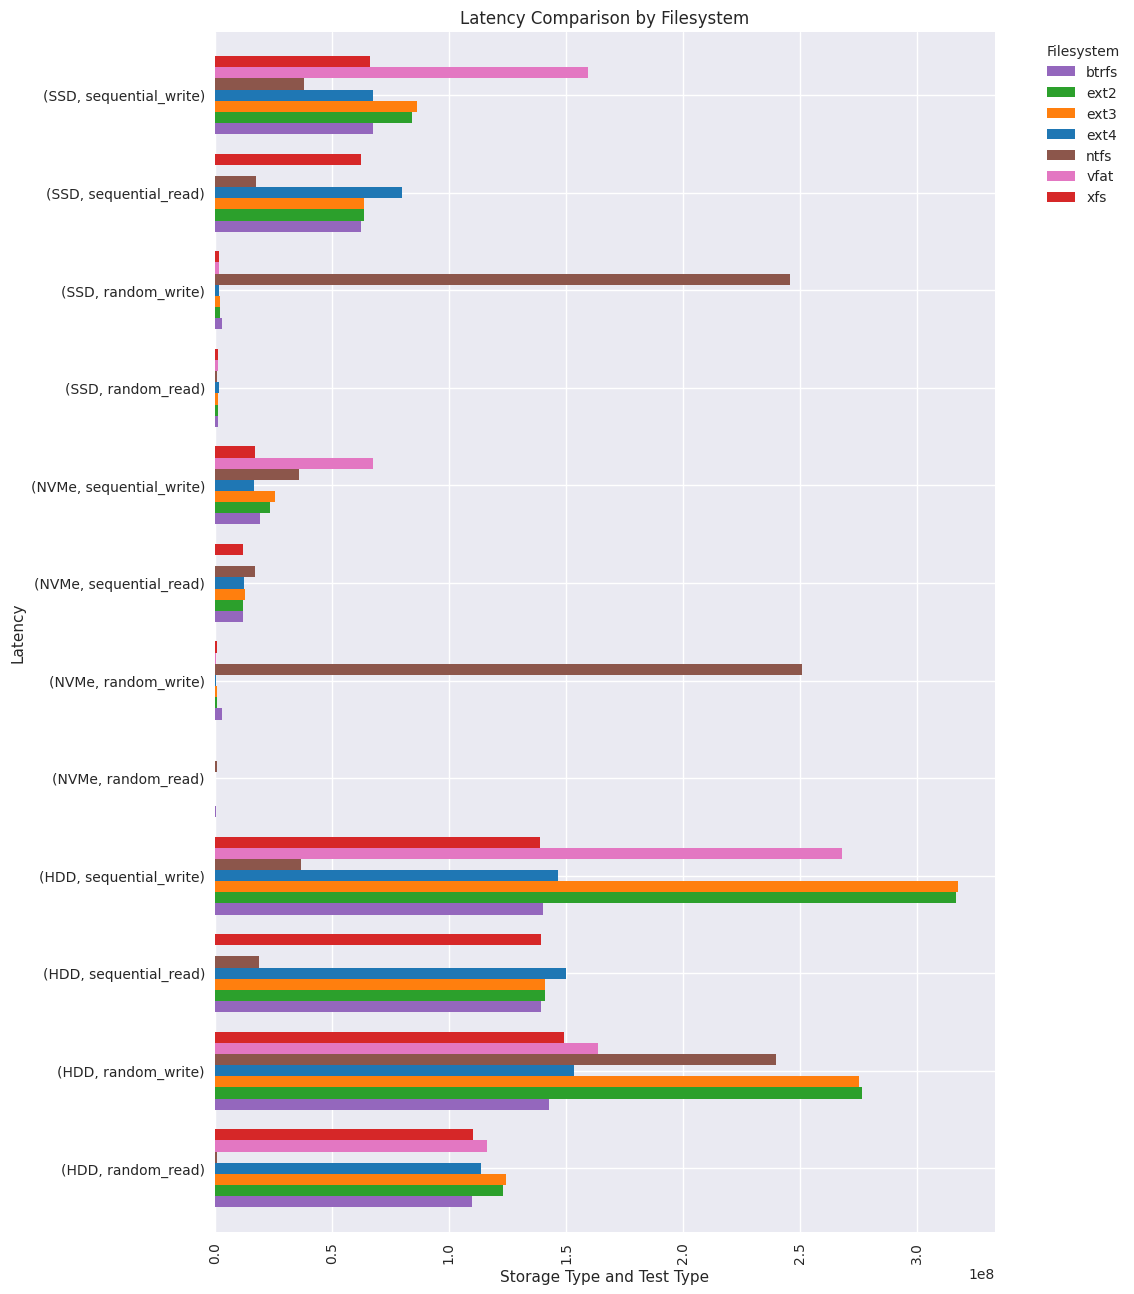

In [6]:
def analyze_filesystem_performance(df):
    """Analyze filesystem performance across different test types."""
    # Create pivot table for each metric
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        pivot = pd.pivot_table(
            df,
            values=metric,
            index=['storage_type', 'test_type'],
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison:")
        display(pivot)
        
        # Plot comparison
        fig, ax = plt.subplots(figsize=(12, 15))
        # Use a distinct color palette with high contrast colors
        pivot.plot(kind='barh', width=0.8, ax=ax, color=fs_colors)  # Increased bar width and custom colors
        plt.title(f'{metric.title()} Comparison by Filesystem')
        plt.xlabel('Storage Type and Test Type')
        plt.ylabel(metric.title())
        plt.xticks(rotation=90)
        plt.legend(title='Filesystem', bbox_to_anchor=(1.05, 1), loc='upper left')
        # Ensure plot takes up full figure size while leaving room for legend
        plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.1)
        plt.show()

analyze_filesystem_performance(df)

## 5. I/O Pattern Analysis <a name="io-analysis"></a>


I/O Pattern Statistics:


iops                                bandwidth                                        latency                                         
                      mean       std     min        max        mean         std       min        max          mean           std          min           max
test_type                                                                                                                                                  
random_read       42426.36  47169.54  257.37  125547.89   169705.00   188678.13    1029.0   502191.0  3.392246e+07  5.348442e+07    254012.28  1.243215e+08
random_write      14546.37  17550.69  115.18   57563.46    58185.10    70202.60     460.0   230253.0  9.132045e+07  1.119830e+08    554805.46  2.765953e+08
sequential_read    1041.52   1047.36    0.00    2656.29  1066514.10  1072498.11       0.0  2720041.0  5.514969e+07  5.533024e+07         0.00  1.498208e+08
sequential_write    685.42    584.35  100.09    1913.12   701863.43   598375.13  102495.0  1959039.0  1.019477e+08  9.465585e+07  16701543.24  3.171924e+08

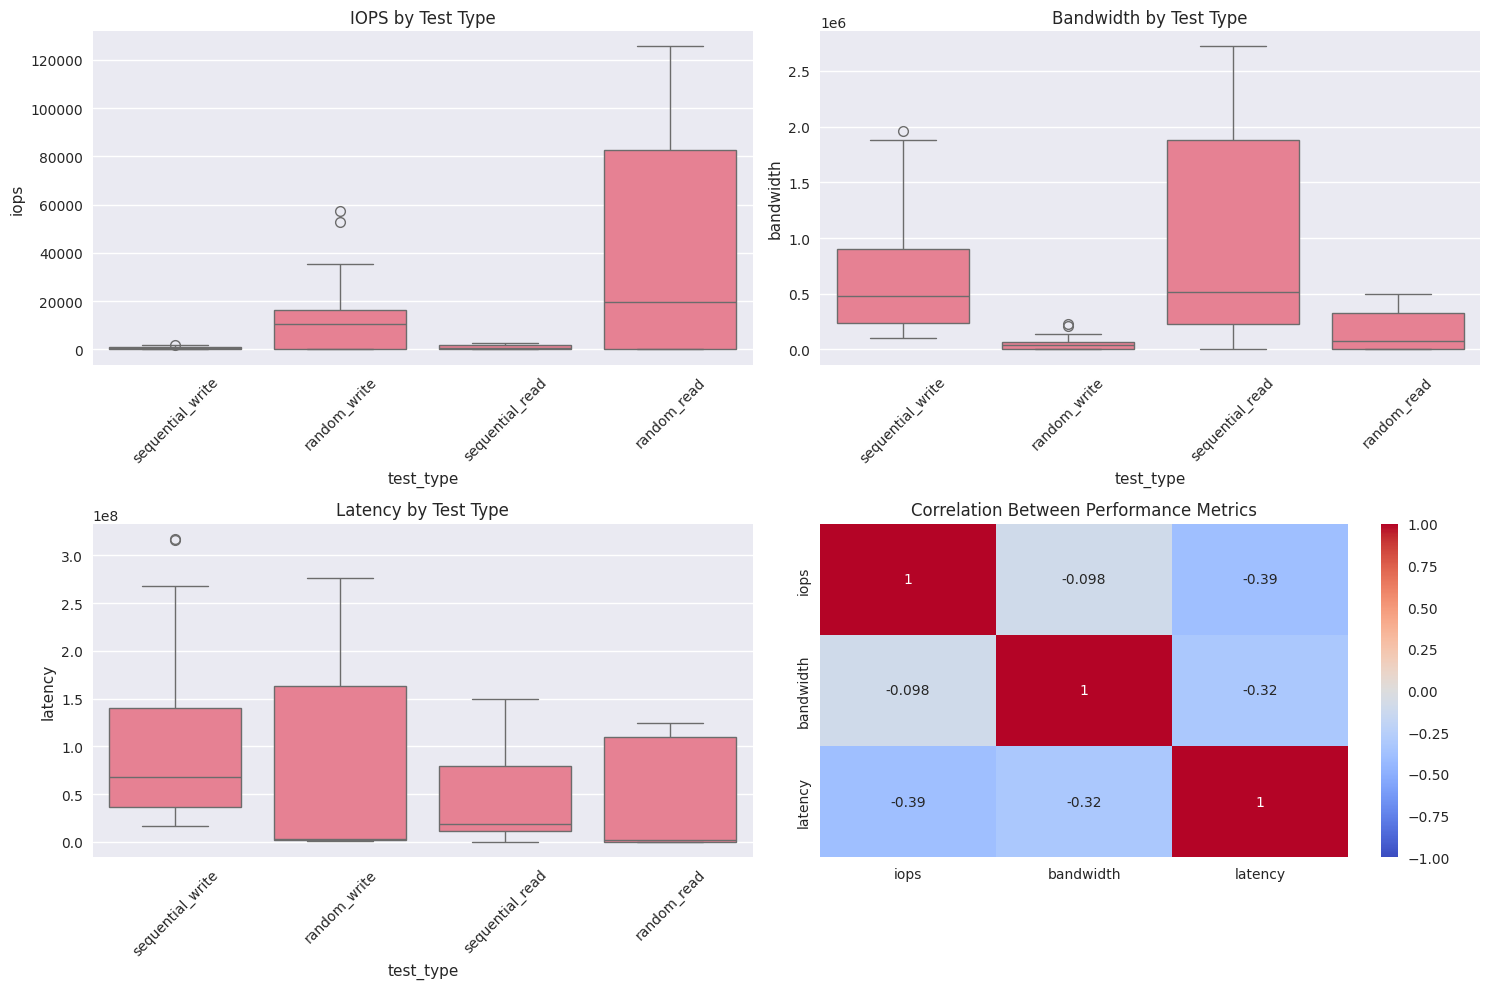

In [7]:
def analyze_io_patterns(df):
    """Analyze I/O patterns across different test types."""
    # Group by test type and calculate statistics
    io_stats = df.groupby('test_type').agg({
        'iops': ['mean', 'std', 'min', 'max'],
        'bandwidth': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("\nI/O Pattern Statistics:")
    display(io_stats)
    
    # Plot I/O patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # IOPS by test type
    sns.boxplot(data=df, x='test_type', y='iops', ax=axes[0,0])
    axes[0,0].set_title('IOPS by Test Type')
    axes[0,0].set_xticks(range(len(df['test_type'].unique())))
    axes[0,0].set_xticklabels(df['test_type'].unique(), rotation=45)
    
    # Bandwidth by test type
    sns.boxplot(data=df, x='test_type', y='bandwidth', ax=axes[0,1])
    axes[0,1].set_title('Bandwidth by Test Type')
    axes[0,1].set_xticks(range(len(df['test_type'].unique())))
    axes[0,1].set_xticklabels(df['test_type'].unique(), rotation=45)
    
    # Latency by test type
    sns.boxplot(data=df, x='test_type', y='latency', ax=axes[1,0])
    axes[1,0].set_title('Latency by Test Type')
    axes[1,0].set_xticks(range(len(df['test_type'].unique())))
    axes[1,0].set_xticklabels(df['test_type'].unique(), rotation=45)
    
    # Create a more meaningful visualization showing relationship between metrics
    # Use a heatmap to show correlation between key performance metrics
    correlation = df[['iops', 'bandwidth', 'latency']].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1,1])
    axes[1,1].set_title('Correlation Between Performance Metrics')
    
    plt.tight_layout()
    plt.show()

analyze_io_patterns(df)

## 6. Resource Utilization <a name="resource-analysis"></a>
### Analytics based on the monitoring data
This section analyzes CPU, memory, and disk I/O utilization patterns across different storage types and filesystems. Note that the NTFS results show significantly higher resource utilization due to its much longer elapsed time (7132 seconds) compared to other filesystems (20-70 seconds), which may skew the overall resource utilization metrics.


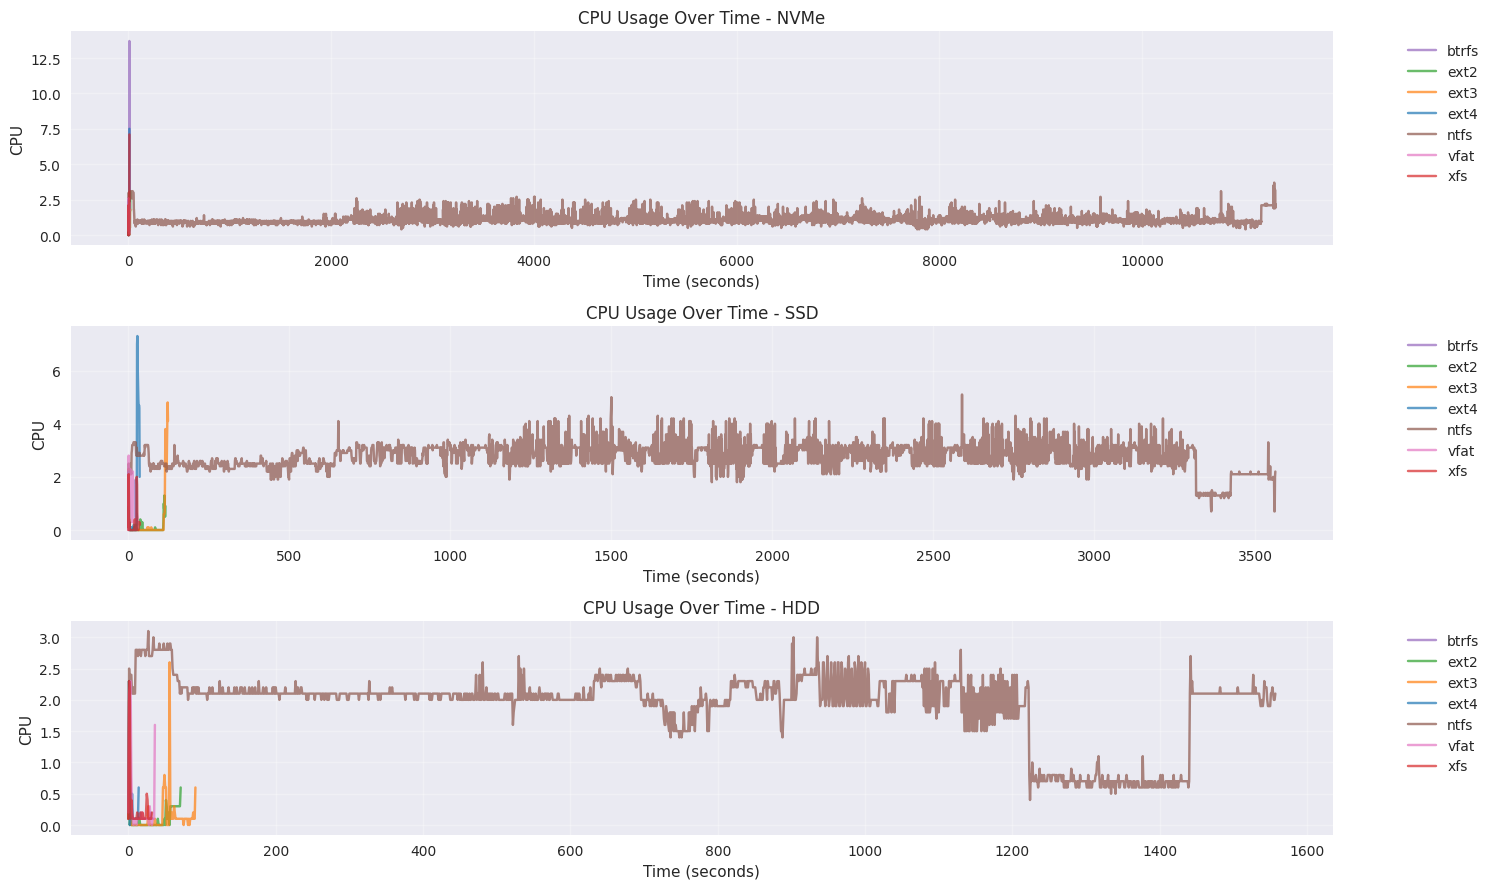

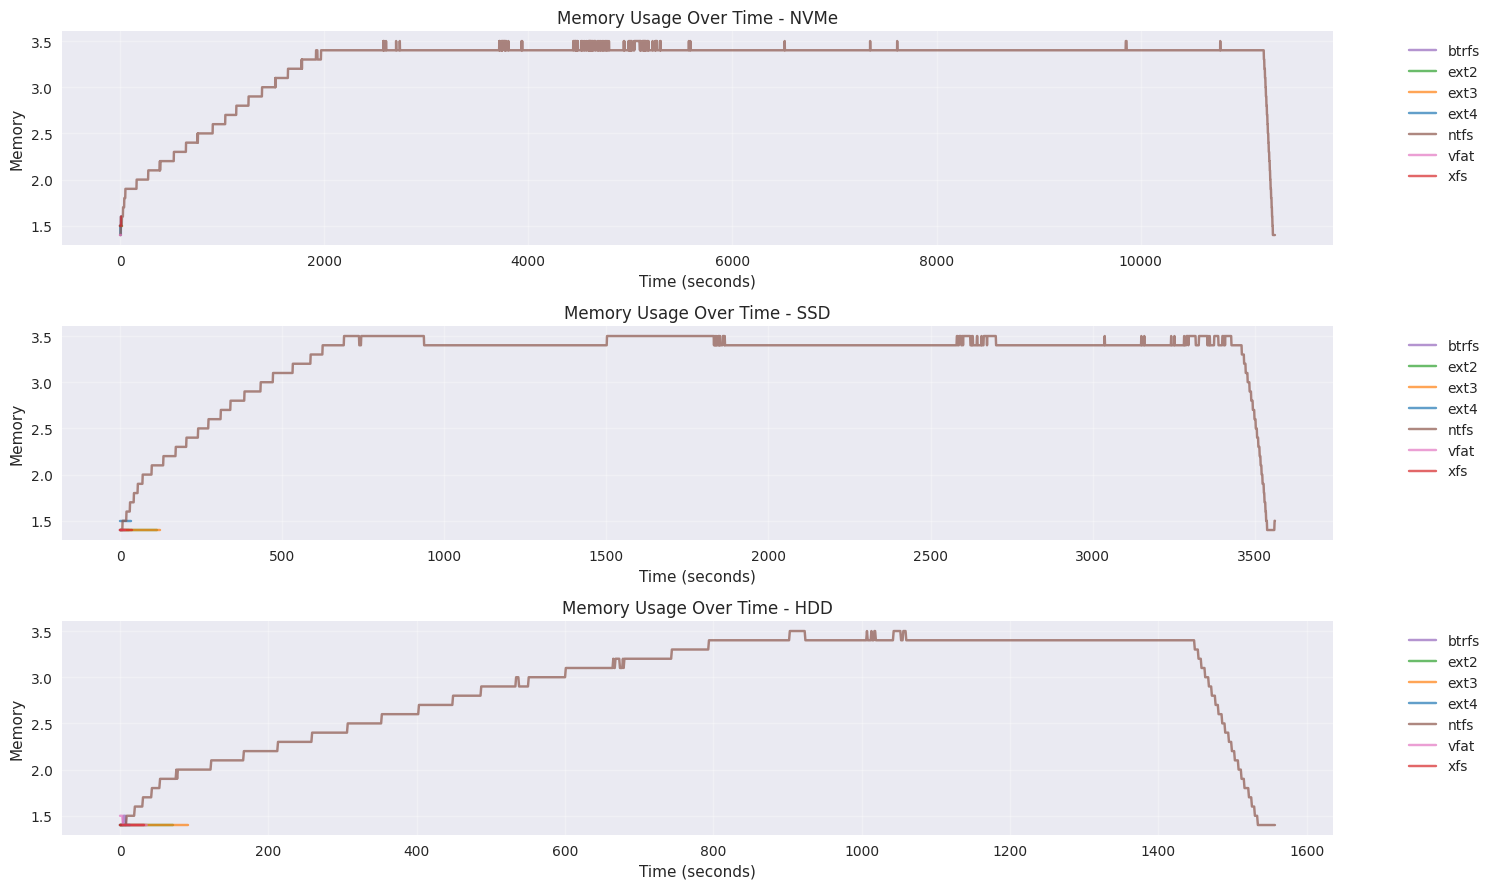

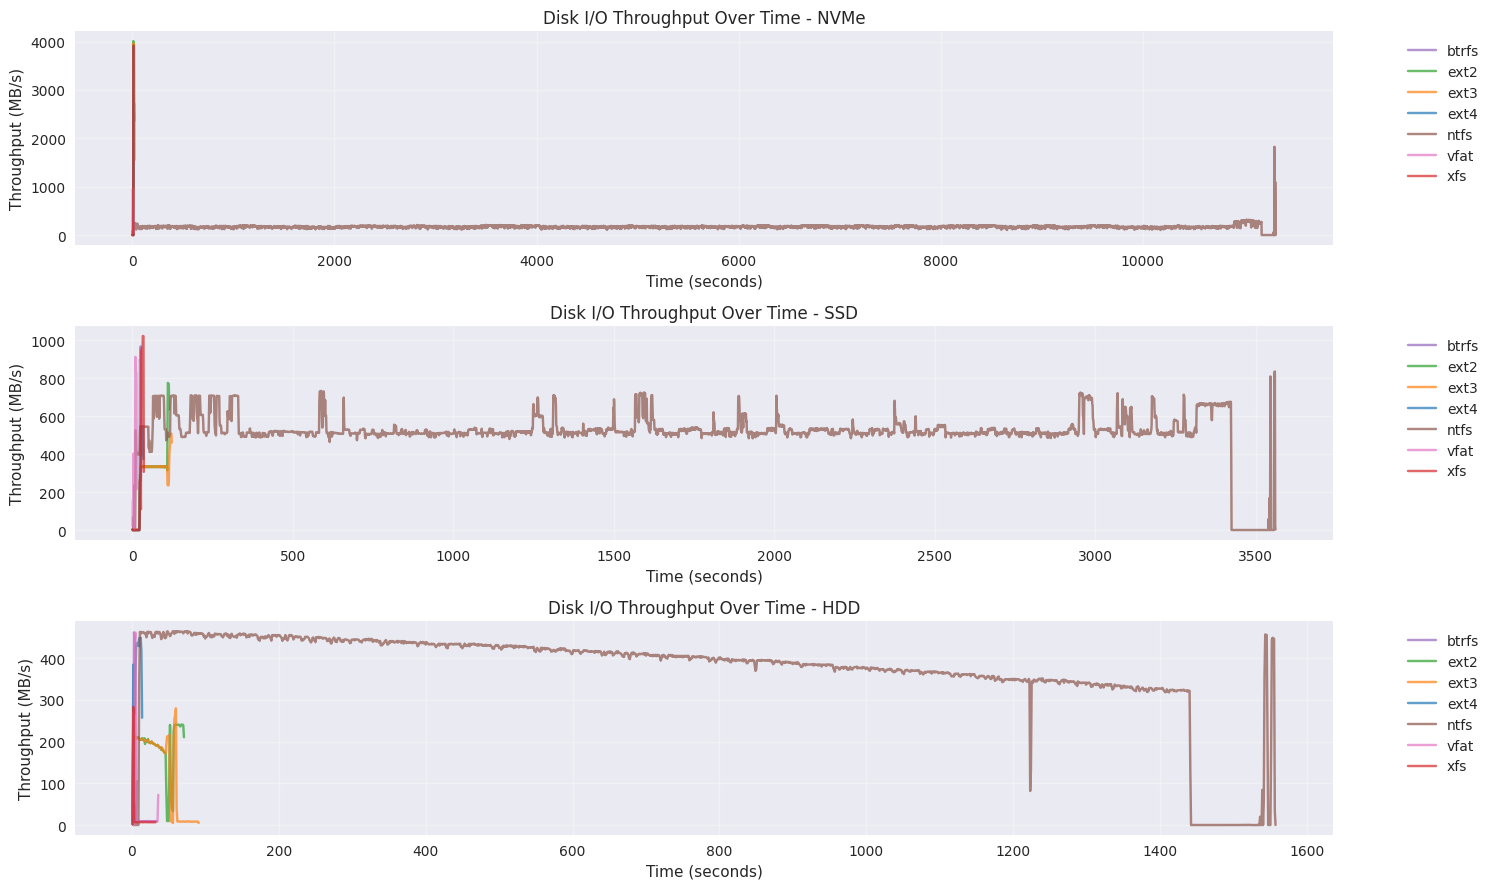

,Storage Type,Filesystem,Avg CPU %,Max CPU %,Avg Memory %,Max Memory %,Total Read (GB),Total Write (GB),Elapsed Time (s)
0,HDD,btrfs,0.222857,2.3,1.408571,1.5,304.714440,3234.096130,68.070094
1,HDD,ext2,0.127778,2.3,1.400000,1.4,291.600677,3161.113423,142.137219
2,HDD,ext3,0.143478,2.6,1.400000,1.4,291.850449,3171.901868,182.176519
3,HDD,ext4,0.306667,2.3,1.400000,1.4,300.175681,3222.764630,28.030823
4,HDD,ntfs,1.918164,3.1,2.910205,3.5,287.261601,2553.800095,3117.673241
5,HDD,vfat,0.332432,2.3,1.410811,1.5,285.962682,861.352174,72.074149
6,HDD,xfs,0.272727,2.3,1.400000,1.4,300.442266,3224.521772,64.065516
7,NVMe,btrfs,2.175000,13.7,1.500000,1.5,403.187676,18510.434410,22.021028
8,NVMe,ext2,0.616667,3.1,1.500000,1.5,374.987468,18340.320305,34.032300
9,NVMe,ext3,0.621053,2.2,1.500000,1.5,383.167312,18474.386311,36.033045


In [8]:
def plot_resource_trends(df, metric, title):
    """
    Plot resource usage trends over time for different storage types and filesystems.
    
    Args:
        df: DataFrame containing the monitoring data
        metric: Metric to plot (e.g., 'cpu_percent', 'memory_percent')
        title: Title for the plot
    """
    # Create subplots for each storage type
    storage_types = df['storage_type'].unique()
    fig, axes = plt.subplots(len(storage_types), 1, figsize=(15, 3*len(storage_types)))
    
    for idx, storage_type in enumerate(storage_types):
        ax = axes[idx]
        
        # Filter data for current storage type
        storage_df = df[df['storage_type'] == storage_type]
        
        for filesystem, group in storage_df.groupby('filesystem'):
            if 'monitor_data' in group.iloc[0] and 'stats' in group.iloc[0]['monitor_data']:
                stats = pd.DataFrame(group.iloc[0]['monitor_data']['stats'])
                stats['timestamp'] = pd.to_datetime(stats['timestamp'])
                ax.plot(range(len(stats)), stats[metric], 
                        label=filesystem,
                        color=fs_colors[filesystem],
                        alpha=0.7)
        
        ax.set_title(f'{title} Usage Over Time - {storage_type}')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot Disk I/O Throughput
def plot_io_throughput(df):
    """
    Plot disk I/O throughput over time for different storage types and filesystems.
    
    Args:
        df: DataFrame containing the monitoring data
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 9))
    storage_types = df['storage_type'].unique()

    for idx, storage_type in enumerate(storage_types):
        ax = axes[idx]
        
        for filesystem, group in df[df['storage_type'] == storage_type].groupby('filesystem'):
            if 'monitor_data' in group.iloc[0] and 'stats' in group.iloc[0]['monitor_data']:
                stats = pd.DataFrame(group.iloc[0]['monitor_data']['stats'])
                stats['timestamp'] = pd.to_datetime(stats['timestamp'])
                
                # Calculate I/O throughput (MB/s)
                stats['io_throughput'] = (stats['disk_read_bytes'].diff() + 
                                        stats['disk_write_bytes'].diff()) / 1024 / 1024
                
                ax.plot(range(len(stats)), stats['io_throughput'], 
                        label=filesystem,
                        color=fs_colors[filesystem],
                        alpha=0.7)
        
        ax.set_title(f'Disk I/O Throughput Over Time - {storage_type}')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Throughput (MB/s)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot CPU Usage
plot_resource_trends(df, 'cpu_percent', 'CPU')

# Plot Memory Usage
plot_resource_trends(df, 'memory_percent', 'Memory')

# Plot Disk I/O Throughput
plot_io_throughput(df)

# Resource usage summary statistics
resource_summary = pd.DataFrame()
for (storage_type, filesystem), group in df.groupby(['storage_type', 'filesystem']):
    if 'monitor_data' in group.iloc[0] and 'stats' in group.iloc[0]['monitor_data']:
        stats = pd.DataFrame(group.iloc[0]['monitor_data']['stats'])
        # Convert timestamp strings to datetime objects
        stats['timestamp'] = pd.to_datetime(stats['timestamp'])
        summary = {
            'Storage Type': storage_type,
            'Filesystem': filesystem,
            'Avg CPU %': stats['cpu_percent'].mean(),
            'Max CPU %': stats['cpu_percent'].max(),
            'Avg Memory %': stats['memory_percent'].mean(),
            'Max Memory %': stats['memory_percent'].max(),
            'Total Read (GB)': stats['disk_read_bytes'].max() / 1024**3,
            'Total Write (GB)': stats['disk_write_bytes'].max() / 1024**3,
            'Elapsed Time (s)': (stats['timestamp'].max() - stats['timestamp'].min()).total_seconds()
        }
        resource_summary = pd.concat([resource_summary, pd.DataFrame([summary])], ignore_index=True)

display(resource_summary)

### Resource Usage Analysis (excluding NTFS)

The following analysis excludes NTFS filesystem results due to caching effects that significantly distort the measurements.
The significantly longer elapsed time for NTFS tests suggests substantial overhead from formatting and mounting operations before the actual benchmark begins.

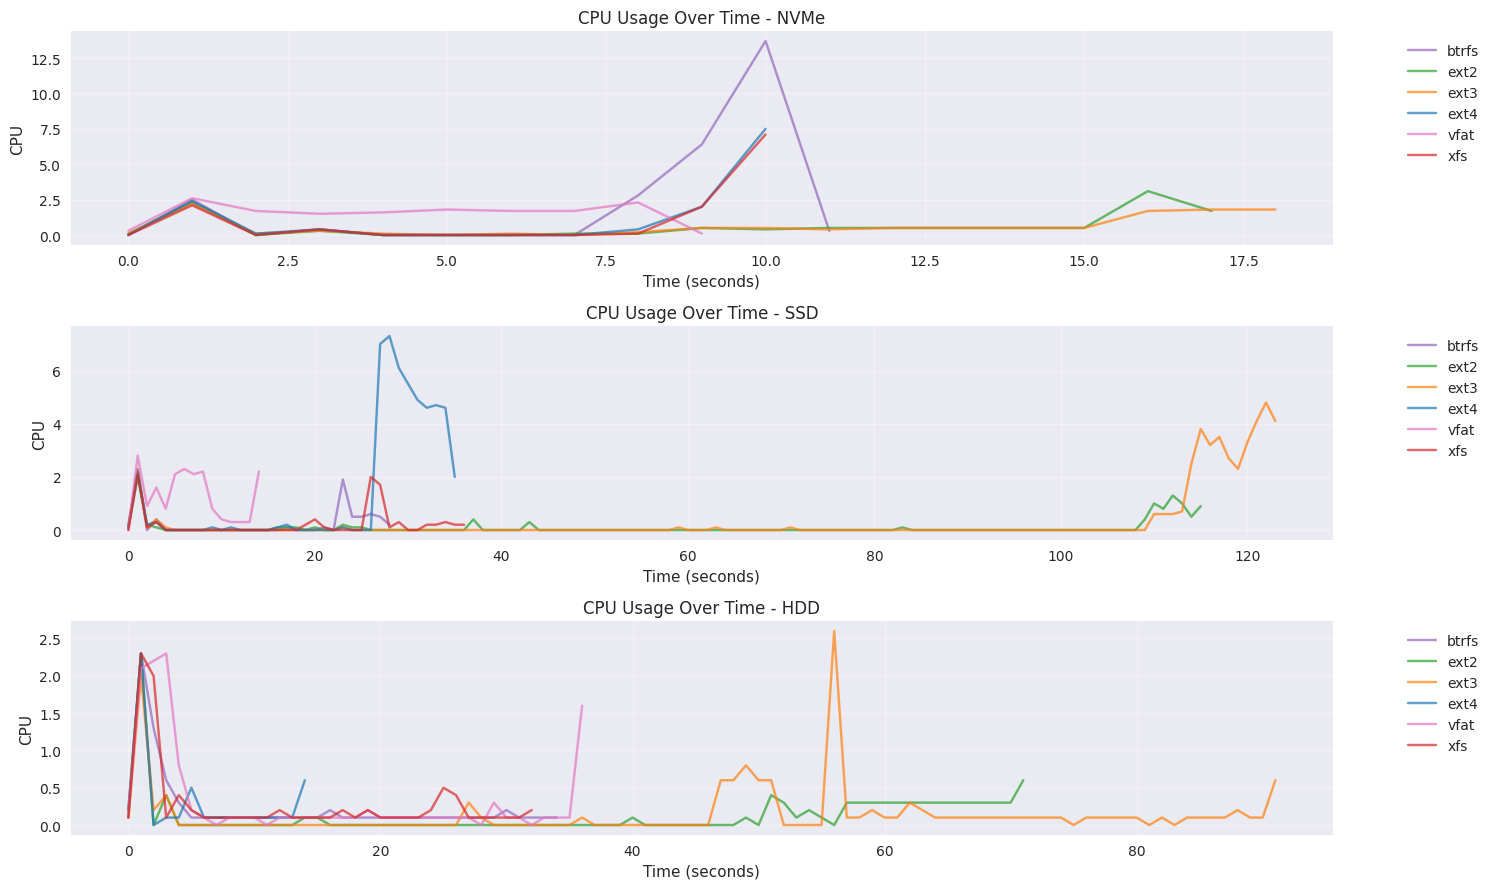

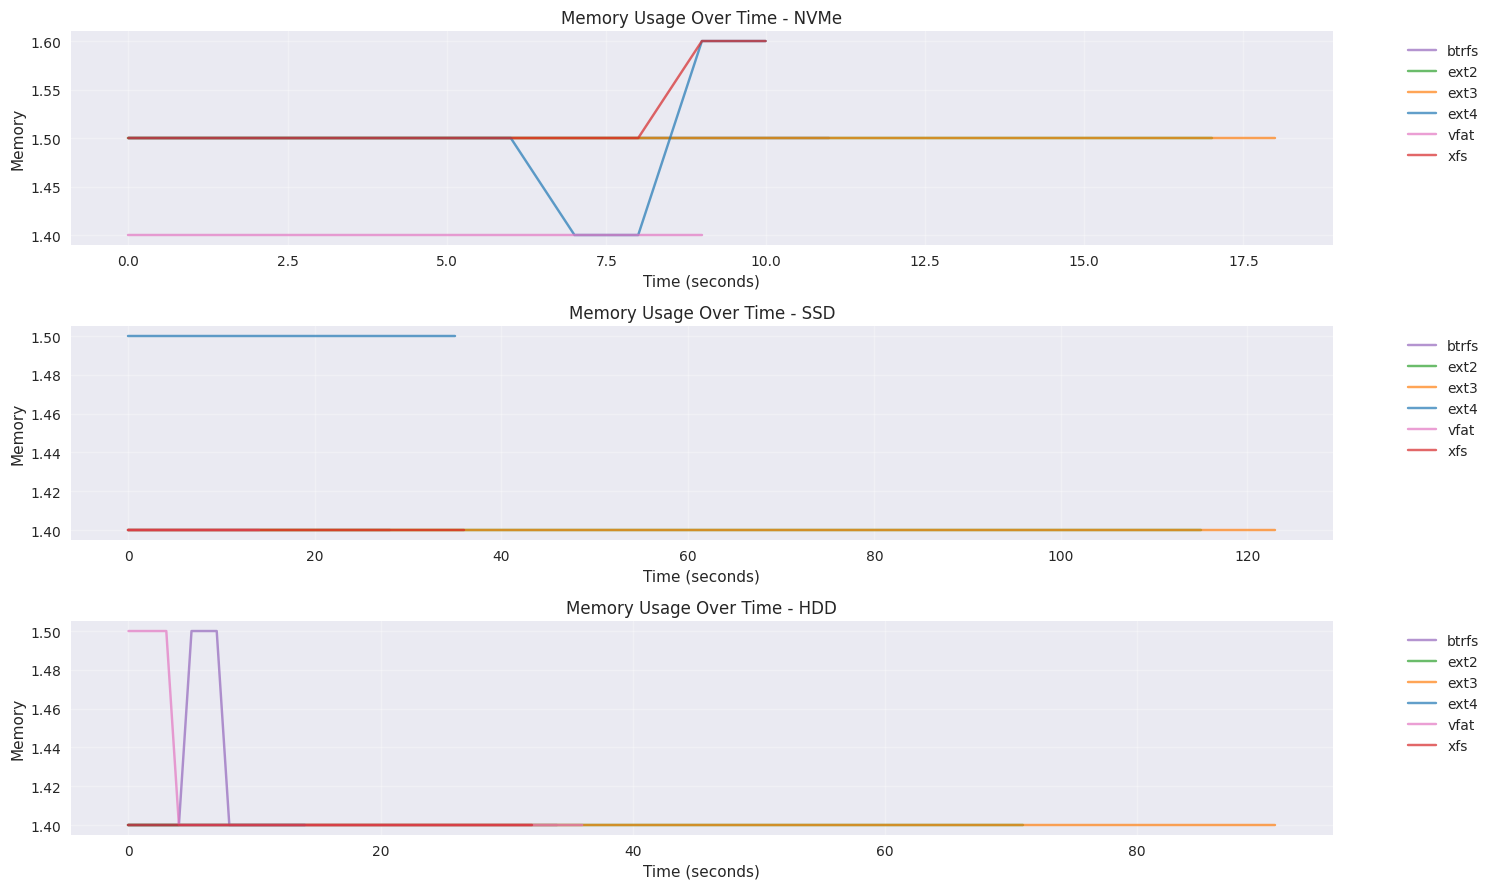

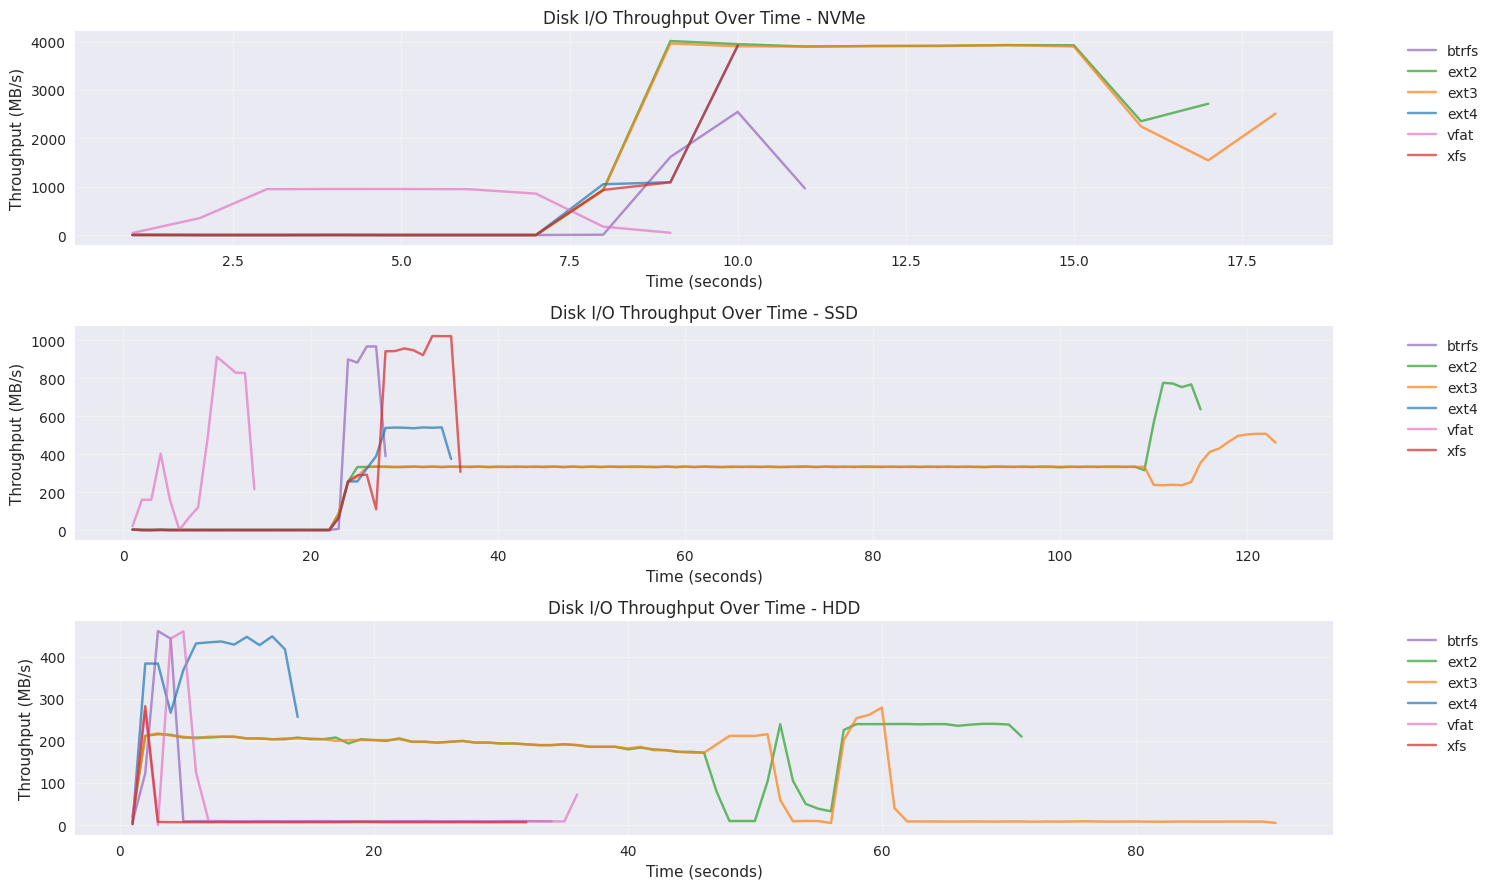

In [9]:
# Plot CPU Usage
plot_resource_trends(df[df['filesystem'] != 'ntfs'], 'cpu_percent', 'CPU')

# Plot Memory Usage
plot_resource_trends(df[df['filesystem'] != 'ntfs'], 'memory_percent', 'Memory')

# Plot Disk I/O Throughput
plot_io_throughput(df[df['filesystem'] != 'ntfs'])

### Resource Usage Matrix Analysis
The resource usage matrix provides a comprehensive visualization of how different filesystems
perform across various storage types, showing the temporal patterns of resource utilization
during different test phases.



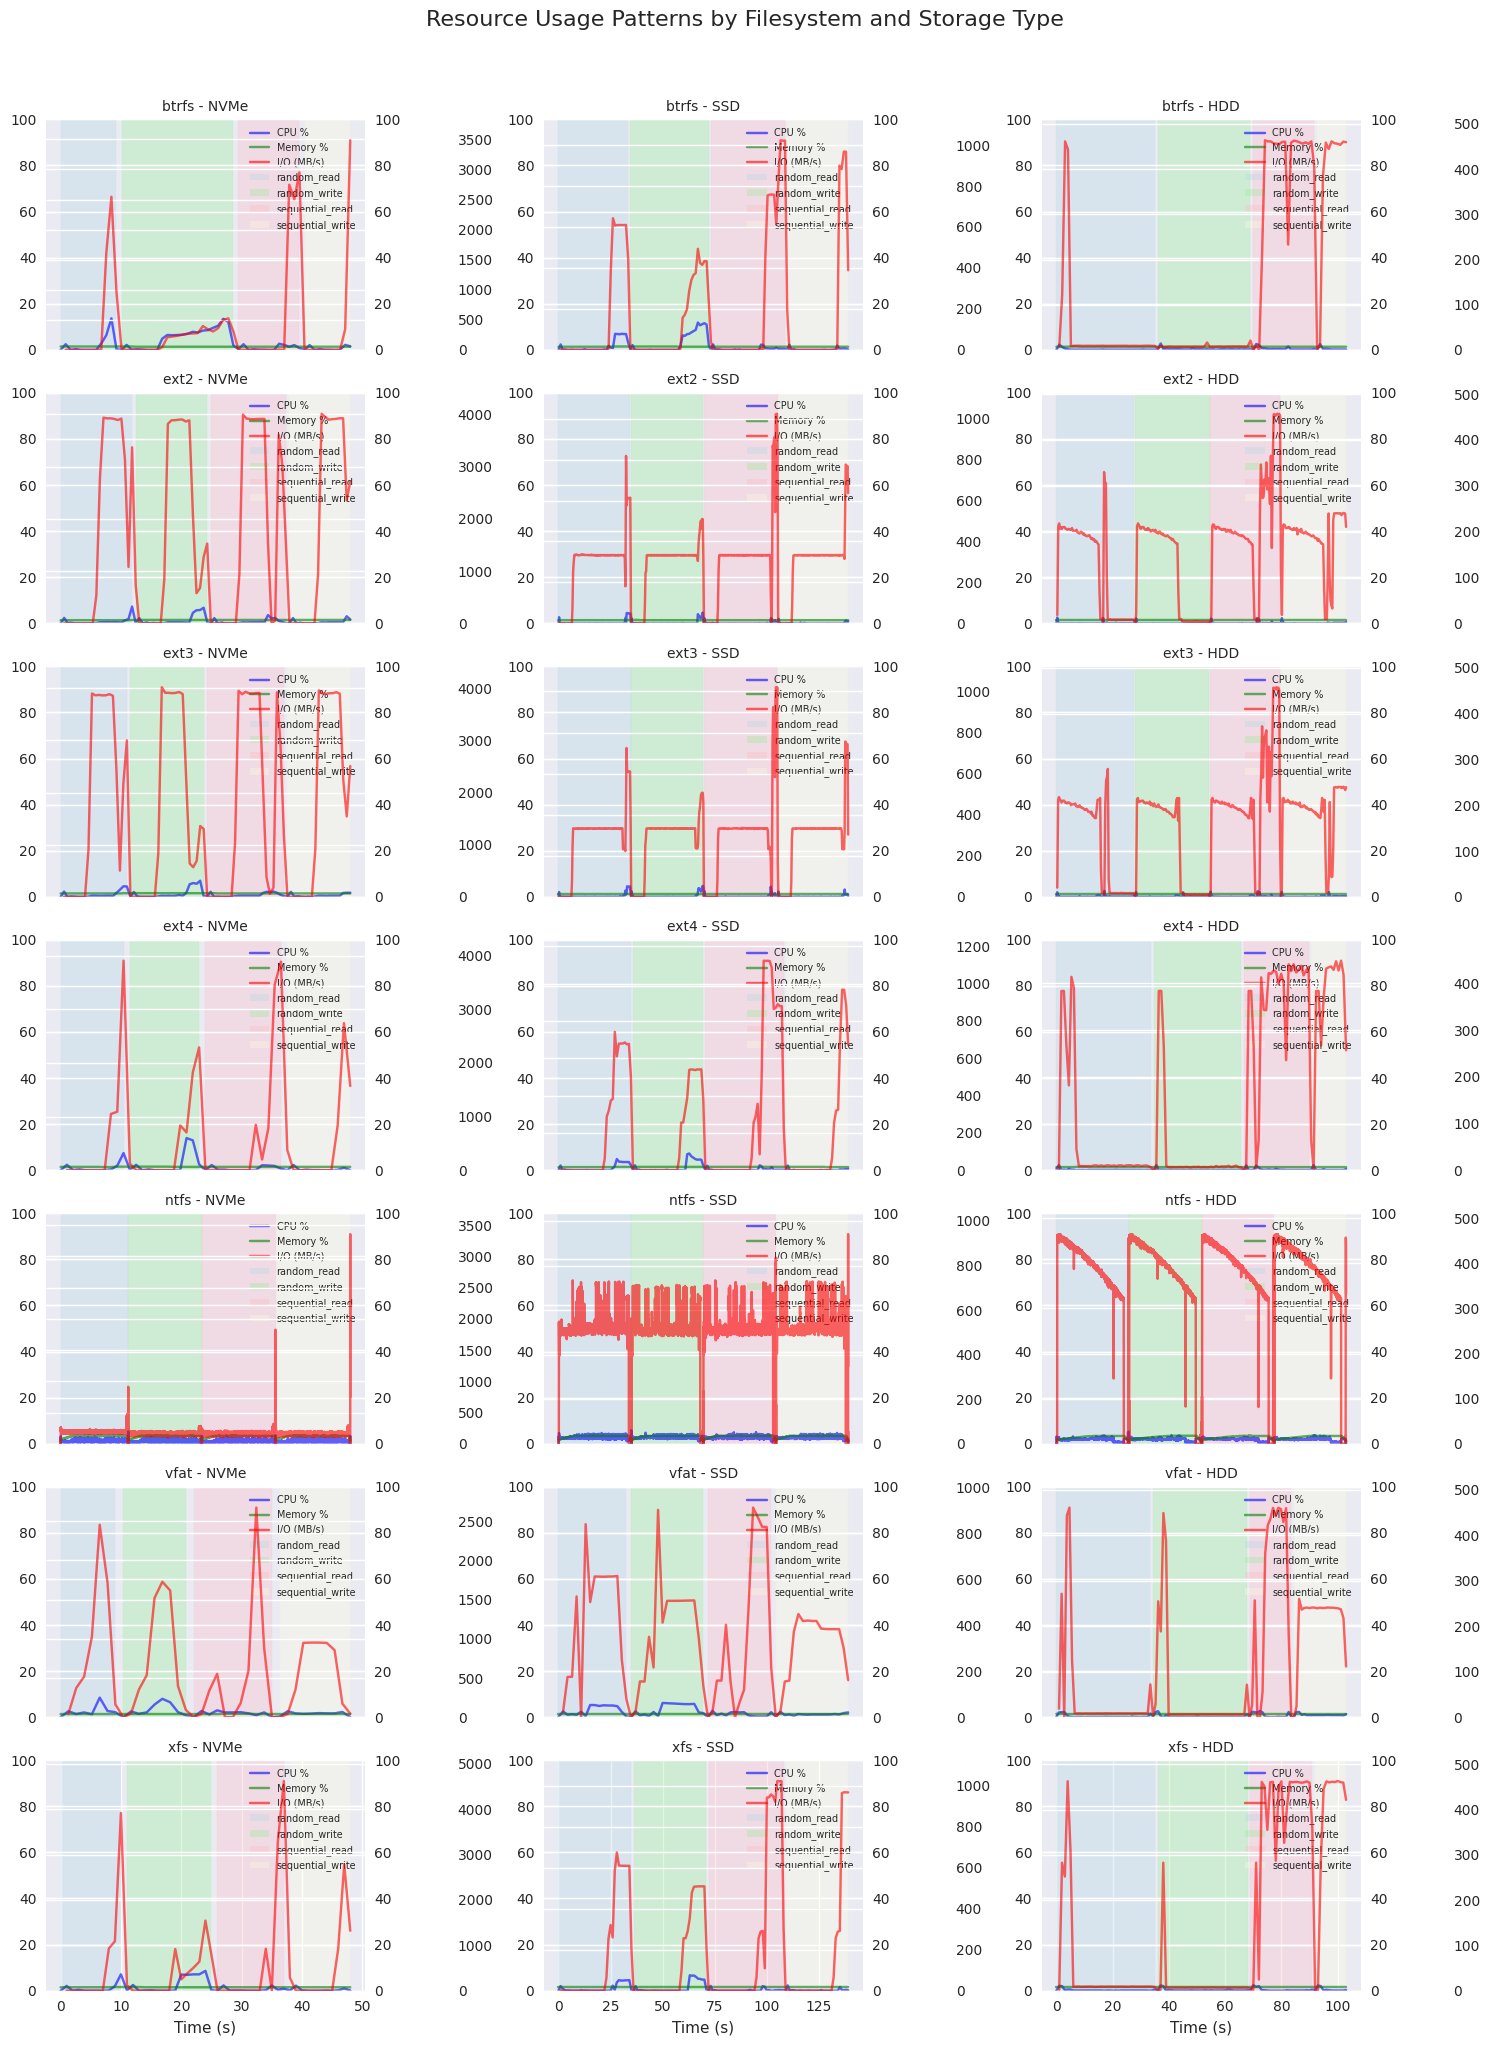

In [10]:
def plot_resource_matrix(df):
    # Get unique storage types and filesystems
    storage_types = df['storage_type'].unique()
    filesystems = df['filesystem'].unique()
    
    # Create a figure with subplots matrix
    fig, axes = plt.subplots(len(filesystems), len(storage_types), 
                            figsize=(15, 20), 
                            squeeze=False)
    
    # Set title for the entire figure
    fig.suptitle('Resource Usage Patterns by Filesystem and Storage Type', 
                 fontsize=16, y=1.02)
    
    # Test phases in order
    test_phases = ['random_read', 'random_write', 'sequential_read', 'sequential_write']
    phase_colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
    
    # Create plots for each combination
    for i, filesystem in enumerate(sorted(filesystems)):
        for j, storage_type in enumerate(storage_types):
            ax = axes[i, j]
            
            # Get all data for this combination
            mask = (df['storage_type'] == storage_type) & (df['filesystem'] == filesystem)
            subset = df[mask]
            
            if len(subset) > 0:
                # Combine monitoring data from all test phases
                all_stats = []
                cumulative_time = 0
                
                for test_type in test_phases:
                    test_data = subset[subset['test_type'] == test_type]
                    if len(test_data) > 0 and 'monitor_data' in test_data.iloc[0] and 'stats' in test_data.iloc[0]['monitor_data']:
                        stats = pd.DataFrame(test_data.iloc[0]['monitor_data']['stats'])
                        stats['timestamp'] = pd.to_datetime(stats['timestamp'])
                        stats['relative_time'] = range(len(stats))
                        stats['absolute_time'] = stats['relative_time'] + cumulative_time
                        stats['test_phase'] = test_type
                        all_stats.append(stats)
                        cumulative_time += len(stats)
                
                if all_stats:
                    combined_stats = pd.concat(all_stats)
                    
                    # Calculate I/O throughput
                    combined_stats['io_throughput'] = (combined_stats['disk_read_bytes'].diff() + 
                                                     combined_stats['disk_write_bytes'].diff()) / 1024 / 1024
                    
                    # Plot three metrics on the same subplot
                    ax2 = ax.twinx()
                    ax3 = ax.twinx()
                    ax3.spines['right'].set_position(('outward', 60))
                    
                    # Plot phase backgrounds
                    for phase_idx, phase in enumerate(test_phases):
                        phase_data = combined_stats[combined_stats['test_phase'] == phase]
                        if not phase_data.empty:
                            start_time = phase_data['absolute_time'].min()
                            end_time = phase_data['absolute_time'].max()
                            ax.axvspan(start_time, end_time,
                                     color=phase_colors[phase_idx],
                                     alpha=0.3,
                                     label=phase)
                    
                    # Plot metrics
                    line1 = ax.plot(combined_stats['absolute_time'], 
                                  combined_stats['cpu_percent'],
                                  color='blue', label='CPU %', alpha=0.6)
                    line2 = ax2.plot(combined_stats['absolute_time'],
                                   combined_stats['memory_percent'],
                                   color='green', label='Memory %', alpha=0.6)
                    line3 = ax3.plot(combined_stats['absolute_time'],
                                   combined_stats['io_throughput'],
                                   color='red', label='I/O (MB/s)', alpha=0.6)
                    
                    # Set labels and limits
                    ax.set_ylim(0, 100)
                    ax2.set_ylim(0, 100)
                    ax3.set_ylim(0, combined_stats['io_throughput'].max() * 1.1)
                    
                    # Add legend
                    lines = line1 + line2 + line3
                    labels = [l.get_label() for l in lines]
                    ax.legend(lines + [plt.Rectangle((0,0),1,1, fc=c, alpha=0.3) for c in phase_colors],
                             labels + test_phases,
                             loc='upper right', 
                             fontsize='x-small')
            
            # Set title for each subplot
            ax.set_title(f'{filesystem} - {storage_type}', fontsize=10)
            
            # Only show x-axis labels for bottom row
            if i == len(filesystems) - 1:
                ax.set_xlabel('Time (s)')
            
            # Clean up unnecessary ticks
            if i != len(filesystems) - 1:
                ax.set_xticks([])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Create the matrix plot
plot_resource_matrix(df)

## 7. Comparative Analysis <a name="comparative-analysis"></a>
This section presents a comparative analysis of storage performance metrics across different configurations. It examines three key performance indicators (IOPS, bandwidth, and latency) by comparing both storage types (HDD, SSD, NVMe) and filesystems (ext4, xfs, btrfs, etc.). The analysis includes both tabular data and visual heatmaps to facilitate easy comparison of performance characteristics.



IOPS Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,5218.303830,100538.353152,21522.412417
random_write,172.426875,30839.360014,12627.320963
sequential_read,401.794746,2118.419987,604.339425
sequential_write,265.055608,1332.734501,458.479528



IOPS Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,34150.718689,48464.614005,47448.554914,47416.674581,35829.873834,36069.845286,47604.213953
random_write,6993.685213,16671.054181,16155.161039,24621.679064,130.452019,23118.157383,14134.396090
sequential_read,1131.475723,1124.197273,1062.197436,1063.653334,1776.860342,0.000000,1132.242261
sequential_write,777.993532,610.454910,569.397336,867.935536,857.595701,263.516017,851.069458


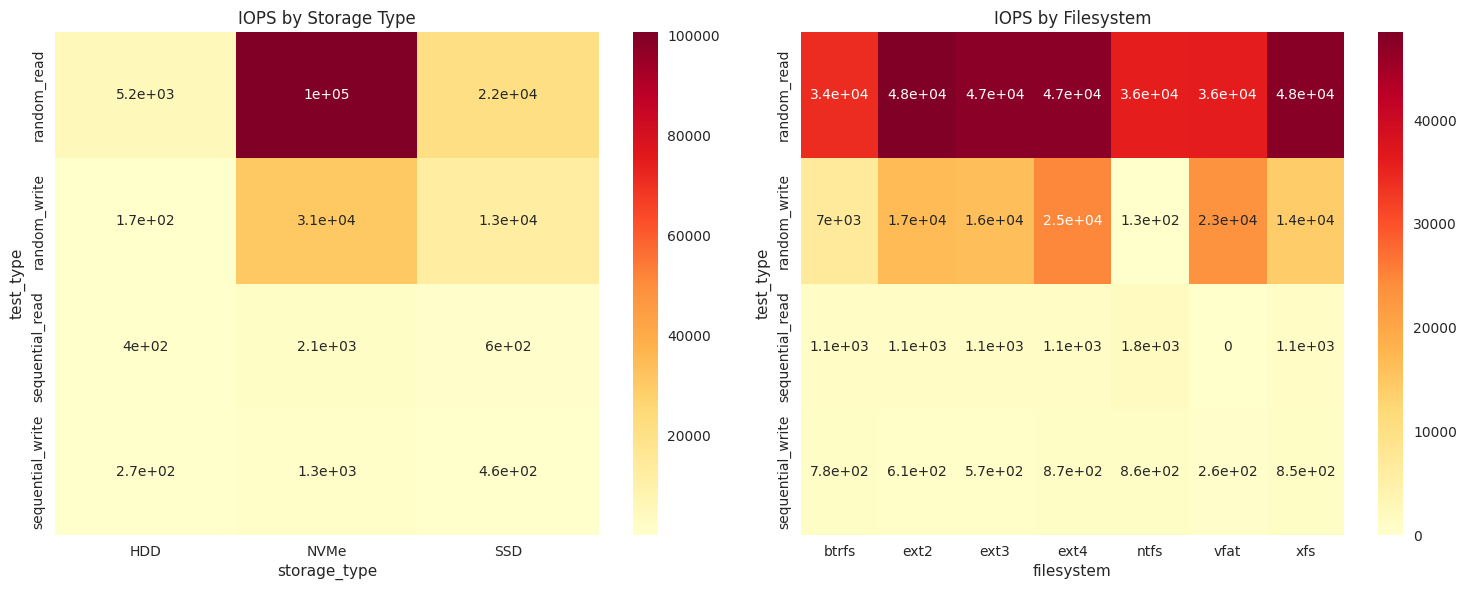


BANDWIDTH Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,20872.714286,4.021530e+05,86089.285714
random_write,689.428571,1.233570e+05,50508.857143
sequential_read,411437.428571,2.169262e+06,618843.285714
sequential_write,271412.142857,1.364703e+06,469475.428571



BANDWIDTH Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,1.366027e+05,1.938580e+05,1.897937e+05,1.896663e+05,1.433190e+05,144279.0,1.904163e+05
random_write,2.797433e+04,6.668367e+04,6.462033e+04,9.848633e+04,5.216667e+02,92472.0,5.653733e+04
sequential_read,1.158631e+06,1.151178e+06,1.087690e+06,1.089181e+06,1.819504e+06,0.0,1.159416e+06
sequential_write,7.966650e+05,6.251050e+05,5.830623e+05,8.887653e+05,8.781777e+05,269774.0,8.714947e+05


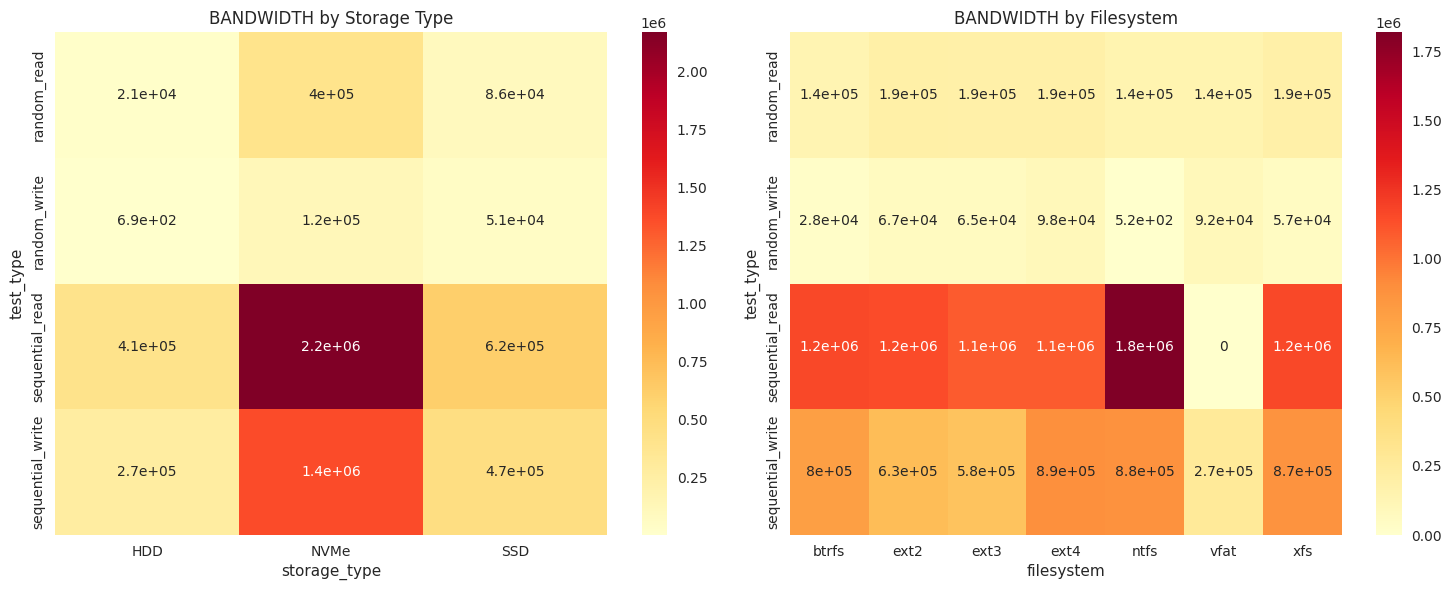


LATENCY Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,9.981976e+07,3.793198e+05,1.568308e+06
random_write,2.000650e+08,3.690734e+07,3.698901e+07
sequential_read,1.041555e+08,1.121463e+07,5.007891e+07
sequential_write,1.949310e+08,2.950203e+07,8.141000e+07



LATENCY Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,3.731838e+07,4.171621e+07,4.207270e+07,3.862764e+07,8.918571e+05,3.947476e+07,3.735570e+07
random_write,4.959191e+07,9.322743e+07,9.275589e+07,5.205853e+07,2.453643e+08,5.539308e+07,5.085198e+07
sequential_read,7.134690e+07,7.228924e+07,7.261188e+07,8.070896e+07,1.785679e+07,0.000000e+00,7.123406e+07
sequential_write,7.580469e+07,1.413831e+08,1.431413e+08,7.700812e+07,3.712815e+07,1.649672e+08,7.420135e+07


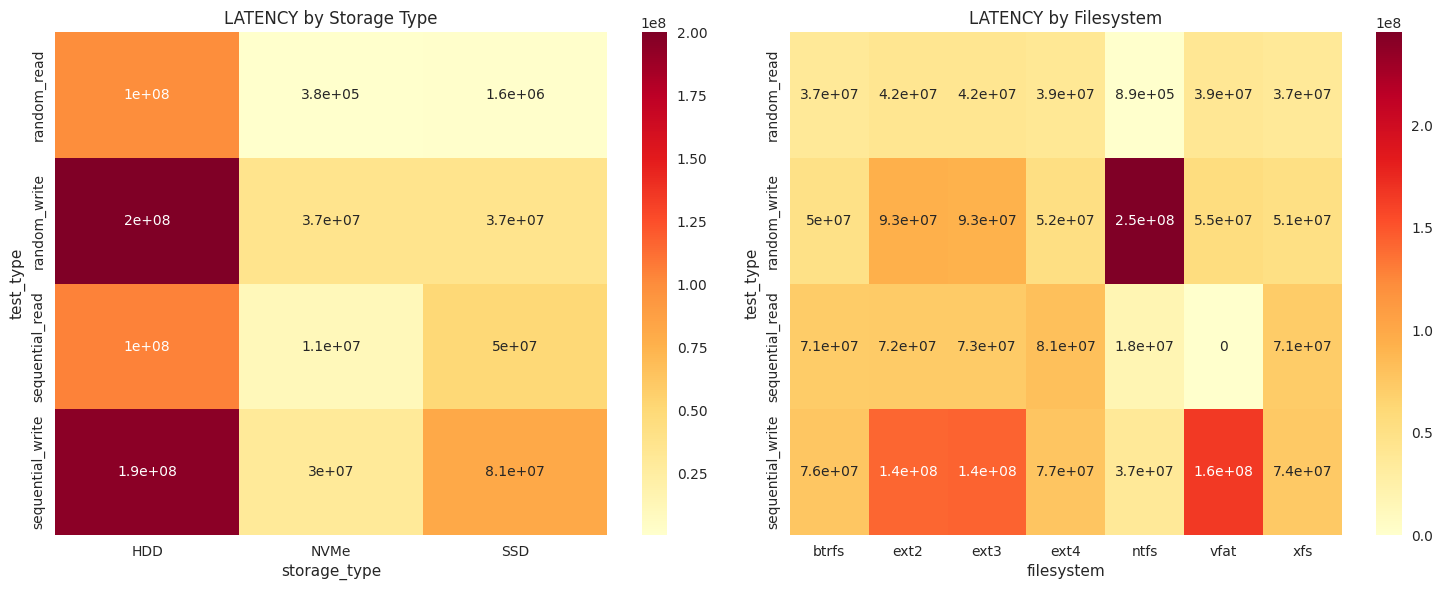

In [11]:
def perform_comparative_analysis(df):
    """Perform comparative analysis between different configurations."""
    # Create comparison matrix
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        # Compare storage types
        storage_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='storage_type',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Storage Type:")
        display(storage_comparison)
        
        # Compare filesystems
        fs_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Filesystem:")
        display(fs_comparison)
        
        # Plot comparison heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.heatmap(storage_comparison, annot=True, cmap='YlOrRd', ax=ax1)
        ax1.set_title(f'{metric.upper()} by Storage Type')
        
        sns.heatmap(fs_comparison, annot=True, cmap='YlOrRd', ax=ax2)
        ax2.set_title(f'{metric.upper()} by Filesystem')
        
        plt.tight_layout()
        plt.show()

perform_comparative_analysis(df)

## 8. Recommendations and Conclusions <a name="conclusions"></a>
This section presents the final analysis and recommendations based on the benchmark results. The analysis uses a geometric mean approach to calculate overall performance scores, taking into account IOPS, bandwidth, and latency metrics. The recommendations are derived from academic literature on storage benchmarking and statistical analysis of results.



Performance Scores and Recommendations:


performance_score      iops   bandwidth       latency
storage_type filesystem                                                       
HDD          btrfs                    0.09    243.20   117599.75  1.330585e+08
             ext2                     0.07    175.52    84171.50  2.143106e+08
             ext3                     0.07    175.02    84067.00  2.144025e+08
             ext4                     0.09    230.31   110971.75  1.409504e+08
             ntfs                     1.36   9388.24   686754.75  7.407539e+07
             vfat                     0.04    147.35    30933.00  1.369791e+08
             xfs                      0.09    241.13   118222.75  1.344233e+08
NVMe         btrfs                    3.19  24226.72  1190281.00  8.778315e+06
             ext2                     4.96  41196.32  1184340.00  9.170515e+06
             ext3                     4.79  39995.97  1103520.25  9.943538e+06
             ext4                     5.63  46855.52  1332587.50  7.463895e+06
             ntfs                     1.43   9796.01   731068.50  7.631343e+07
             vfat                     5.12  35424.96   261890.75  1.713611e+07
             xfs                      4.74  38455.01  1300392.00  7.700020e+06
SSD          btrfs                    0.97   7820.49   282023.75  3.370955e+07
             ext2                     1.06   8780.89   259106.75  3.798088e+07
             ext3                     1.06   8755.49   256287.25  3.859024e+07
             ext4                     1.02   8391.63   256014.75  3.788818e+07
             ntfs                     1.42   9761.84   713318.75  7.554200e+07
             vfat                     1.32   9016.33    87070.00  4.076104e+07
             xfs                      1.11   9095.30   289783.25  3.310901e+07

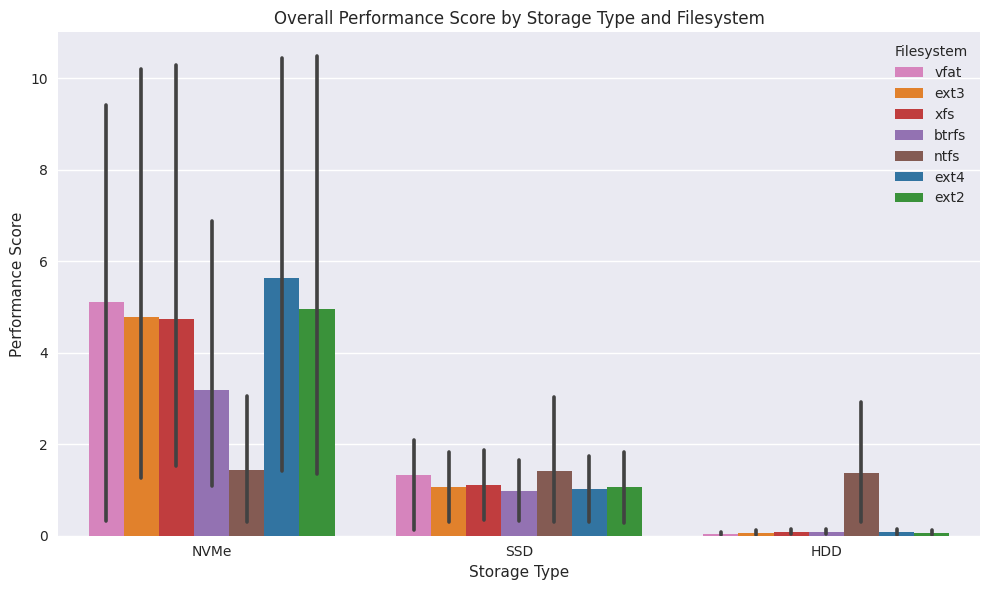

In [12]:
def generate_recommendations(df):
    """Generate recommendations based on benchmark results."""
    # Calculate performance scores using geometric mean of normalized metrics
    # Useful insights from publications:
    # M. Seltzer and K. A. Smith, “Workload-specific file system benchmarks,” 2001. Accessed: May 03, 2025. [Online]. Available: https://www.semanticscholar.org/paper/Workload-specific-file-system-benchmarks-Seltzer-Smith/686de8280485ad66f0b8037ff61e61b494ce3bc0
    # P. M. Chen and D. A. Patterson, “A new approach to I/O performance evaluation: self-scaling I/O benchmarks, predicted I/O performance,” SIGMETRICS Perform. Eval. Rev., vol. 21, no. 1, pp. 1–12, Jun. 1993, doi: 10.1145/166962.166966.
    # P. J. Fleming and J. J. Wallace, “How not to lie with statistics: the correct way to summarize benchmark results,” Commun. ACM, vol. 29, no. 3, pp. 218–221, Mar. 1986, doi: 10.1145/5666.5673.

    
    # Normalize each metric relative to its mean
    normalized_iops = df['iops'] / df['iops'].mean()
    normalized_bandwidth = df['bandwidth'] / df['bandwidth'].mean()
    normalized_latency = df['latency'].mean() / df['latency']  # Invert latency since lower is better
    
    # Calculate geometric mean as recommended by Fleming & Wallace
    # Geometric mean preserves ratios and prevents domination by any single metric
    df['performance_score'] = (normalized_iops * normalized_bandwidth * normalized_latency) ** (1/3)
    
    # Group by storage type and filesystem
    recommendations = df.groupby(['storage_type', 'filesystem']).agg({
        'performance_score': 'mean',
        'iops': 'mean',
        'bandwidth': 'mean',
        'latency': 'mean'
    }).round(2)
    
    print("\nPerformance Scores and Recommendations:")
    display(recommendations)
    
    # Plot performance scores
    plt.figure(figsize=(10, 6))
    

    
    sns.barplot(data=df, x='storage_type', y='performance_score', hue='filesystem', 
                palette=fs_colors)
    plt.title('Overall Performance Score by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel('Performance Score')
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

generate_recommendations(df)